# Coursework


Import TensorFlow and other libaries:

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
import seaborn as sns
print("TensorFlow version:", tf.__version__)

from tensorflow.keras import Model, Sequential, layers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, Rescaling, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt

TensorFlow version: 2.18.0


## Hyperparameters

Define hyperparameters

In [ ]:
IMG_PATH = "C:\\Users\\sandy\\Source\\repos\\Programming Files - repos\\Artificial Intelligence\\brain_tumor_dataset"
IMG_SIZE = (256, 256)
VAL_SPLIT = 0.2
BATCH_SIZE = 16
EPOCHS = 20

Checks if it has access to the folder where the dataset is stored.

In [ ]:
# Set the path to your folder - MAKE SURE THIS EXISTS!
folder_path = IMG_PATH # Update with the actual path

# Now you can access the folder and its contents
os.listdir(folder_path)
yes_images_path = os.path.join(folder_path, "yes")
no_images_path = os.path.join(folder_path, "no")
print(len(os.listdir(yes_images_path)))
print(len(os.listdir(no_images_path)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
150
73


## Preprocessing Stage

Load the images from the Brain Tumour Dataset

In [ ]:
def load_and_preprocess_images(image_path, img_size, label_value):
    images = []
    labels = []

    # Load all images from the directory
    for filename in os.listdir(image_path):
        if filename.endswith((".jpg", ".png", ".jpeg", ".bmp", ".JPG")):  # Handle other image formats
            img = load_img(os.path.join(image_path, filename), target_size=img_size)
            img_array = img_to_array(img)  # Convert image to array
            images.append(img_array)
            labels.append(label_value)  # Use the label passed to the function

    return np.array(images), np.array(labels)

# Load 'yes' and 'no' images
yes_images, yes_labels = load_and_preprocess_images(yes_images_path, IMG_SIZE, 1)
no_images, no_labels = load_and_preprocess_images(no_images_path, IMG_SIZE, 0)

print("Number of 'yes' images:", len(yes_images))
print("Number of 'no' images:", len(no_images))

Number of 'yes' images: 150
Number of 'no' images: 73


Apply Data Augmentation to the images

In [ ]:
# Normalize the images
yes_images = yes_images.astype('float32') / 255.0
no_images = no_images.astype('float32') / 255.0

# Ensure that labels are reshaped to match the number of images
yes_labels = yes_labels.reshape(-1, 1)  # Reshape to (num_samples, 1)
no_labels = no_labels.reshape(-1, 1)    # Reshape to (num_samples, 1)

# Check if reshaped labels match the number of images
assert yes_images.shape[0] == yes_labels.shape[0], "Mismatch between yes_images and yes_labels count"
assert no_images.shape[0] == no_labels.shape[0], "Mismatch between no_images and no_labels count"

# Initialize the data augmentor
Data_augmentator = ImageDataGenerator(
    rotation_range=30,        # Randomly rotates images by up to 20 degrees
    width_shift_range=0.2,    # Shifts images horizontally by up to 10% of the width
    height_shift_range=0.2,   # Shifts images vertically by up to 10% of the height
    shear_range=0.2,          # Applies shear transformations (distortion along an axis)
    zoom_range=0.2,           # Randomly zooms images in or out by up to 10%
    horizontal_flip=True,     # Randomly flips images horizontally
    fill_mode='constant'      # Fills empty pixels created by transformations with a constant value
)

# Fit the augmenter on the 'yes' and 'no' images
yes_images_augmented = Data_augmentator.flow(yes_images, yes_labels, batch_size=BATCH_SIZE)
no_images_augmented = Data_augmentator.flow(no_images, no_labels, batch_size=BATCH_SIZE)

# The desired number of images being augmented
num_augmentations = 500

# Augment the 'yes' images
augmented_yes_images = []
augmented_yes_labels = []
for i in range(num_augmentations // BATCH_SIZE + 1):  # Generate enough augmented images
    batch_images, batch_labels = next(yes_images_augmented)
    augmented_yes_images.append(batch_images)
    augmented_yes_labels.append(batch_labels)

# Convert list to numpy array
augmented_yes_images = np.vstack(augmented_yes_images)
augmented_yes_labels = np.vstack(augmented_yes_labels)

# Get the imbalance between the two classes
extra_augmentations = num_augmentations + (len(yes_images) - len(no_images))

# Augment the 'no' images (for balancing)
augmented_no_images = []
augmented_no_labels = []
for i in range(extra_augmentations// BATCH_SIZE + 1):  # Generate enough augmented images
    batch_images, batch_labels = next(no_images_augmented)
    augmented_no_images.append(batch_images)
    augmented_no_labels.append(batch_labels)

# Convert list to numpy array
augmented_no_images = np.vstack(augmented_no_images)
augmented_no_labels = np.vstack(augmented_no_labels)

# Combine 'yes' and 'no' images into one dataset
final_images = np.vstack([augmented_yes_images, augmented_no_images])
final_labels = np.vstack([augmented_yes_labels, augmented_no_labels])

# Shuffle the dataset
indices = np.random.permutation(len(final_images))
final_images = final_images[indices]
final_labels = final_labels[indices]

# Check that final_images and final_labels have matching shapes
assert final_images.shape[0] == final_labels.shape[0], "Mismatch between final_images and final_labels count"


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing (or validation)
X_train, X_test, y_train, y_test = train_test_split(final_images, final_labels, test_size=0.2, random_state=42)

# Now, create a TensorFlow Dataset for the training set (train_ds)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Optional: Batch and shuffle the dataset for efficient training
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

# Check the shape of the first batch in train_ds to ensure correct label shape
for train_images, train_labels in train_ds.take(1):
    print(f"Train images shape: {train_images.shape}")
    print(f"Train labels shape: {train_labels.shape}")


Train images shape: (16, 256, 256, 3)
Train labels shape: (16, 1)


Checks if the images from the dataset have been loaded and prepared.

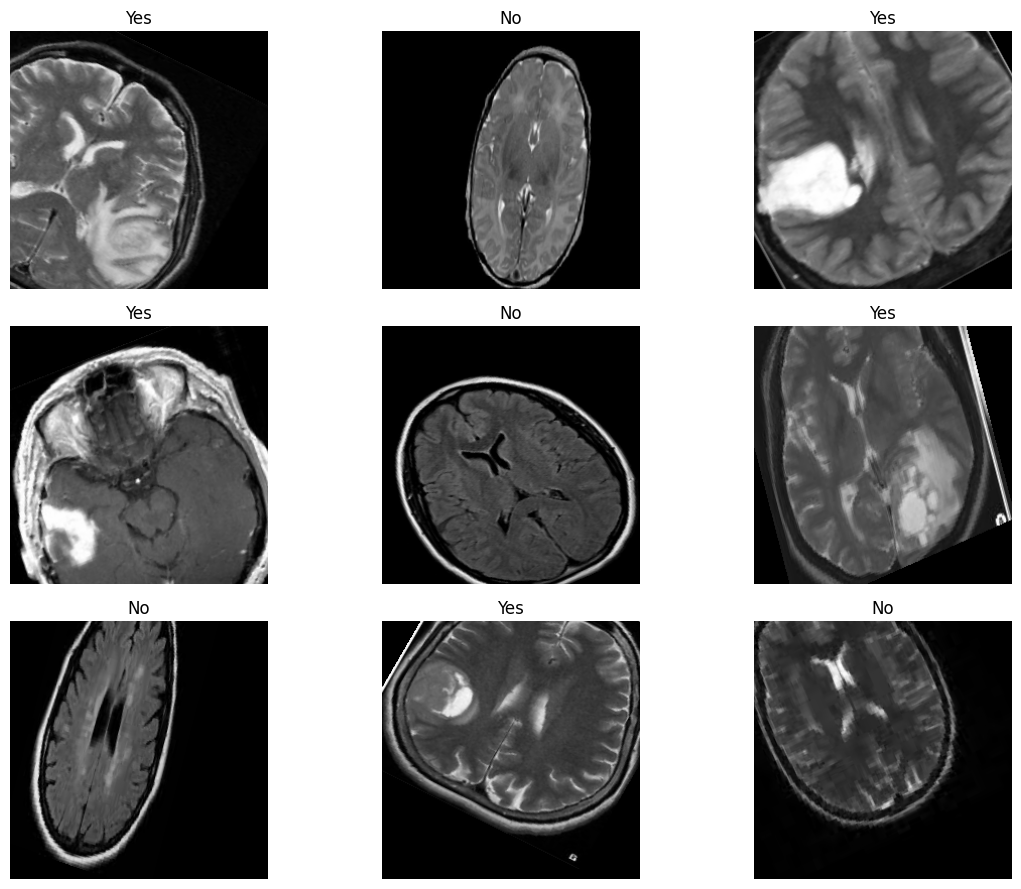

In [ ]:
# Get a batch of images from the dataset
for images, labels in train_ds.take(1):
    fig, axes = plt.subplots(3, 3, figsize=(12, 9))  # 3 rows, 3 columns

    for i in range(9):  # Loop over the first 9 images in the batch
        image = images[i].numpy()  # Convert the image from TensorFlow tensor to numpy array

        # Plot the image without heatmap
        ax = axes[i // 3, i % 3]  # Adjust the row and column index for 3x3 grid
        ax.imshow(image)
        ax.axis("off")  # Turn off axis
        ax.set_title("Yes" if labels[i][0] == 1 else "No")  # Display 'Yes' or 'No' based on the labels

    plt.tight_layout()
    plt.show()
    break  # Show only one batch

Data augment and Normalize the data

In [ ]:
# Normalize data correctly
normalization_layer = Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))  # No augmentation on validation

In [ ]:
# Count the number of original 'yes' and 'no' images
num_original_yes_images = yes_images.shape[0]  # Number of original 'yes' images
num_original_no_images = no_images.shape[0]    # Number of original 'no' images

# Count the number of augmented 'yes' and 'no' images
num_augmented_yes_images = augmented_yes_images.shape[0]  # Number of augmented 'yes' images
num_augmented_no_images = augmented_no_images.shape[0]    # Number of augmented 'no' images

# Total images after augmentation
total_yes_images = num_original_yes_images + num_augmented_yes_images
total_no_images = num_original_no_images + num_augmented_no_images

# Total images in the entire dataset
total_images = total_yes_images + total_no_images

# Print the counts
print(f"Original 'Yes' images: {num_original_yes_images}")
print(f"Original 'No' images: {num_original_no_images}")
print(f"Augmented 'Yes' images: {num_augmented_yes_images}")
print(f"Augmented 'No' images: {num_augmented_no_images}")
print(f"Total images: {total_images}")


Original 'Yes' images: 150
Original 'No' images: 73
Augmented 'Yes' images: 482
Augmented 'No' images: 543
Total images: 1248


## Model Construction

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [ ]:
class MyModel(Model):
  def __init__(self):
    super().__init__()

    kernReg = 0.01

    self.conv1 = Conv2D(32, (3, 3), activation=None, padding = 'same', kernel_regularizer=regularizers.l2(kernReg), input_shape = (IMG_SIZE, 3))
    self.batch_norm1 = BatchNormalization()
    self.pool1 = MaxPooling2D(2, 2)

    self.conv2 = Conv2D(64, (3, 3), activation=None, padding = 'same', kernel_regularizer=regularizers.l2(kernReg))
    self.batch_norm2 = BatchNormalization()
    self.pool2 = MaxPooling2D(2, 2)

    self.conv3 = Conv2D(128, (3, 3), activation=None, padding = 'same', kernel_regularizer=regularizers.l2(kernReg))
    self.batch_norm3 = BatchNormalization()
    self.pool3 = MaxPooling2D(2, 2)

    self.flatten = Flatten()

    self.dense1 = Dense(256, activation='relu')
    self.dropout1 = Dropout(0.5)
    self.dense2 = Dense(128, activation='relu')
    self.dropout2 = Dropout(0.5)

    self.dense3 = Dense(1, activation='sigmoid')

  def call(self, x):
    x = self.conv1(x)
    x = tf.nn.relu(x)
    x = self.batch_norm1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = tf.nn.relu(x)
    x = self.batch_norm2(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = tf.nn.relu(x)
    x = self.batch_norm3(x)
    x = self.pool3(x)

    x = self.flatten(x)

    x = self.dense1(x)
    x = self.dropout1(x)
    x = self.dense2(x)
    x = self.dropout2(x)

    return self.dense3(x)

# Create an instance of the model
model = MyModel()

# Build the model
model.build(input_shape=(None, IMG_SIZE, 3))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'my_model_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### Training and Testing

Choose an optimizer and loss function for training:

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [ ]:
# Callbacks for better training efficiency
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

Use `tf.GradientTape` to train the model:

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy.update_state(labels, predictions)

Test the model:

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy.update_state(labels, predictions)

## Model Evaluation

In [ ]:
# Initialize Early Stopping Parameters
patience = 10  # Number of epochs to wait before stopping
best_val_loss = np.inf  # Start with a very high value
wait = 0  # Counter for early stopping
best_weights = None  # Store the best model weights

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_state()
    train_accuracy.reset_state()
    test_loss.reset_state()
    test_accuracy.reset_state()

    # Training Step
    for train_images, train_labels in train_ds:
        train_step(train_images, train_labels)

    # Validation Step
    for test_images, test_labels in val_ds:
        test_step(test_images, test_labels)

    # Get current validation loss and accuracy
    current_val_loss = test_loss.result().numpy()
    current_test_acc = test_accuracy.result().numpy()

    # Print training and test metrics
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result():0.2f}, '
        f'Accuracy: {train_accuracy.result() * 100:0.2f}, '
        f'Test Loss: {test_loss.result():0.2f}, '
        f'Test Accuracy: {test_accuracy.result() * 100:0.2f}'
    )

    # Early Stopping Logic
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_weights = model.get_weights()  # Save best weights
        wait = 0  # Reset patience counter
    else:
        wait += 1  # Increment patience counter
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            model.set_weights(best_weights)  # Restore best weights
            break  # Stop training


Epoch 1, Loss: 0.69, Accuracy: 58.17, Test Loss: 0.69, Test Accuracy: 53.17
Epoch 2, Loss: 0.69, Accuracy: 53.05, Test Loss: 0.69, Test Accuracy: 53.17
Epoch 3, Loss: 0.69, Accuracy: 53.29, Test Loss: 0.69, Test Accuracy: 53.17
Epoch 4, Loss: 0.69, Accuracy: 53.66, Test Loss: 0.68, Test Accuracy: 54.63
Epoch 5, Loss: 0.68, Accuracy: 56.83, Test Loss: 0.68, Test Accuracy: 60.98
Epoch 6, Loss: 0.68, Accuracy: 61.34, Test Loss: 0.67, Test Accuracy: 62.93
Epoch 7, Loss: 0.66, Accuracy: 64.39, Test Loss: 0.66, Test Accuracy: 60.49
Epoch 8, Loss: 0.65, Accuracy: 64.76, Test Loss: 0.65, Test Accuracy: 68.29
Epoch 9, Loss: 0.64, Accuracy: 67.44, Test Loss: 0.63, Test Accuracy: 66.34
Epoch 10, Loss: 0.64, Accuracy: 64.02, Test Loss: 0.64, Test Accuracy: 61.46
Epoch 11, Loss: 0.62, Accuracy: 68.66, Test Loss: 0.62, Test Accuracy: 66.83
Epoch 12, Loss: 0.61, Accuracy: 67.56, Test Loss: 0.63, Test Accuracy: 67.80
Epoch 13, Loss: 0.61, Accuracy: 67.80, Test Loss: 0.62, Test Accuracy: 66.83
Epoch 14

Compile the model and provide a summary of the model

In [ ]:
# Model summary
model.summary()

Model: "my_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (16, 256, 256, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (16, 256, 256, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (16, 128, 128, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (16, 128, 128, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (16, 64, 64, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (16, 64, 64, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (16, 131072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (16, 256)                   │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (16, 128)                   │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (16, 1)                     │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,681,857 (128.49 MB)

 Trainable params: 33,681,409 (128.48 MB)

 Non-trainable params: 448 (1.75 KB)

Retrieve the data from the model

In [ ]:
data = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks=[early_stopping, reduce_lr]  # Using both callbacks
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.7047 - loss: 1.9271 - val_accuracy: 0.6927 - val_loss: 1.9582 - learning_rate: 1.0000e-05
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.7129 - loss: 1.9044 - val_accuracy: 0.6829 - val_loss: 1.9340 - learning_rate: 1.0000e-05
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7118 - loss: 1.8887 - val_accuracy: 0.6927 - val_loss: 1.9166 - learning_rate: 1.0000e-05
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7314 - loss: 1.8664 - val_accuracy: 0.6780 - val_loss: 1.9002 - learning_rate: 1.0000e-05
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6804 - loss: 1.8825 - val_accuracy: 0.6976 - val_loss: 1.8810 - learning_rate: 1.0000e-05
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6956 - loss: 1.8370 - val_accuracy: 0.6878 - val_loss: 1.8666 - learning_rate: 1.0000e-05
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.688

Display the accuracy trend and loss trend of the model

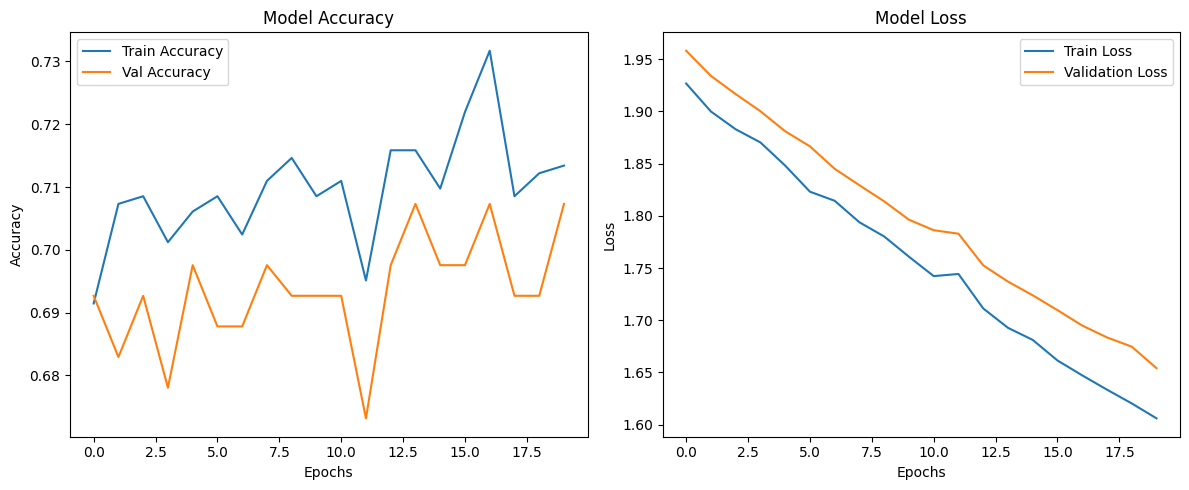

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axes[0].plot(data.history['accuracy'], label='Train Accuracy')
axes[0].plot(data.history['val_accuracy'], label='Val Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Model Accuracy')

# Loss plot
axes[1].plot(data.history['loss'], label='Train Loss')
axes[1].plot(data.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Model Loss')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Show Confusion Matrix of Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


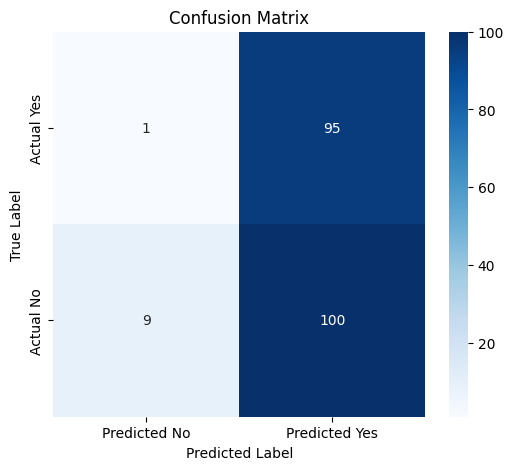

In [ ]:
# 1. Make predictions on the test set
y_pred_probs = model.predict(X_test)  # Get probability outputs
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to 0 or 1

# 2. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 3. Flip the order of the confusion matrix rows (so "Yes" is on top)
cm = np.flipud(cm)

# 4. Create a heatmap visualization
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted No", "Predicted Yes"],
            yticklabels=["Actual Yes", "Actual No"])  # Swapped order

# 5. Add labels to the heatmap
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

Display the overall results of the model

In [ ]:
# Extract labels from the validation dataset
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Predict on validation data
y_pred = (model.predict(val_ds) > 0.5).astype("int32")  # Convert probabilities to 0/1

# Print classification report
print(classification_report(y_true, y_pred, target_names=["No Tumor", "Tumor"]))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
              precision    recall  f1-score   support

    No Tumor       0.72      0.74      0.73       109
       Tumor       0.70      0.67      0.68        96

    accuracy                           0.71       205
   macro avg       0.71      0.70      0.71       205
weighted avg       0.71      0.71      0.71       205

